In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.80

verbose = False
paperpath = "./data/newparticulate_covidstat.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wso2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wpm10_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "avg_wpm10_period1_2020,"+\
        "avg_wso2_period1_2020,"+\
        "avg_wno_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = in_datapaper
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   perugia
   2   brindisi
   3   agrigento
   4   potenza
   5   pavia
   6   trapani
   7   macerata
   8   verona
   9   forli
   10   pesaro
   11   chieti
   12   terni
   13   grosseto
   14   genova
   15   palermo
   16   gorizia
   17   massa
   18   frosinone
   19   reggio_di_calabria
   20   vicenza
   21   roma
   22   l_aquila
   23   rimini
   24   udine
   25   pistoia
   26   isernia
   27   cosenza
   28   benevento
   29   como
   30   nuoro
   31   oristano
   32   crotone
   33   brescia
   34   lucca
   35   bat
   36   bergamo
   37   sassari
   38   firenze
   39   milano
   40   pescara
   41   ascoli_piceno
   42   vercelli
   43   padova
   44   cuneo
   45   biella
   46   lecce
   47   cremona
   48   monza
   49   prato
   50   piacenza
   51   pordenone
   52   avellino
   53   verbania
   54   campobasso
   55   rieti
   56   matera
   57   siracusa
   58   mantova
   59   savo

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
           ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 perugia
2 brindisi
3 agrigento
4 potenza
5 pavia
6 trapani
7 macerata
8 verona
9 forli
10 pesaro
11 chieti
12 terni
13 grosseto
14 genova
15 palermo
16 gorizia
17 massa
18 frosinone
19 reggio_di_calabria
20 vicenza
21 roma
22 l_aquila
23 rimini
24 udine
25 pistoia
26 cosenza
27 benevento
28 como
29 nuoro
30 oristano
31 crotone
32 brescia
33 lucca
34 bat
35 bergamo
36 sassari
37 firenze
38 milano
39 pescara
40 ascoli_piceno
41 vercelli
42 padova
43 cuneo
44 biella
45 lecce
46 cremona
47 monza
48 prato
49 piacenza
50 pordenone
51 avellino
52 verbania
53 campobasso
54 rieti
55 matera
56 siracusa
57 mantova
58 savona
59 pisa
60 ragusa
61 parma
62 ravenna
63 catania
64 imperia
65 trieste
66 asti
67 taranto
68 fermo
69 napoli
70 ancona
71 arezzo
72 foggia
73 lodi
74 livorno
75 siena
76 enna
77 caserta
78 sondrio
79 salerno
80 lecco
81 rovigo
82 alessandria
83 bari
84 trento
85 venezia
86 torino
87 catanzaro
88 bolzano
89 teramo
90 treviso
91 caltanissetta
92 bologna
93 latina
94 novara
95 

In [4]:
#add random feature
import random

featurestobeused += ",randomfeature"
features_dict["randomfeature"] = np.zeros(len(ylogpropcasi), dtype="float64")

random.seed(1)
for i in range(len(ylogpropcasi)):
    features_dict["randomfeature"][i] = random.random()


In [5]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                print(v1, v2, corr)

    if len(highcorrelated[v1]) > 0:
        print(v1)
        for fntr in highcorrelated[v1]:
            print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
Using:                        density
Using:               commutersdensity
Using:                         depriv
Using:                            lat
Using:                 Ratio0200ver65
Using:         avg_wpm10_period1_2020
Using:          avg_wso2_period1_2020
Using:           avg_wno_period1_2020
Using:                  randomfeature

 


In [6]:
feats_innet_to_visualnamemap = {"density" : "Density",
                                "commutersdensity" : "Com. Density",                          
                                "depriv" : "Depriv. Index",
                                "lat" : "Latitude",
                                "Ratio0200ver65" : "Old Young Ratio",
                                "avg_wpm10_period1_2020" : "Avg. PM10",
                                "avg_wno_period1_2020" : "Avg. NO",
                                "avg_wpans_period1_2020" : "Avg. PANS",
                                "avg_wso2_period1_2020" : "Avg. SO2",
                                "randomfeature" : "Random Feat."}

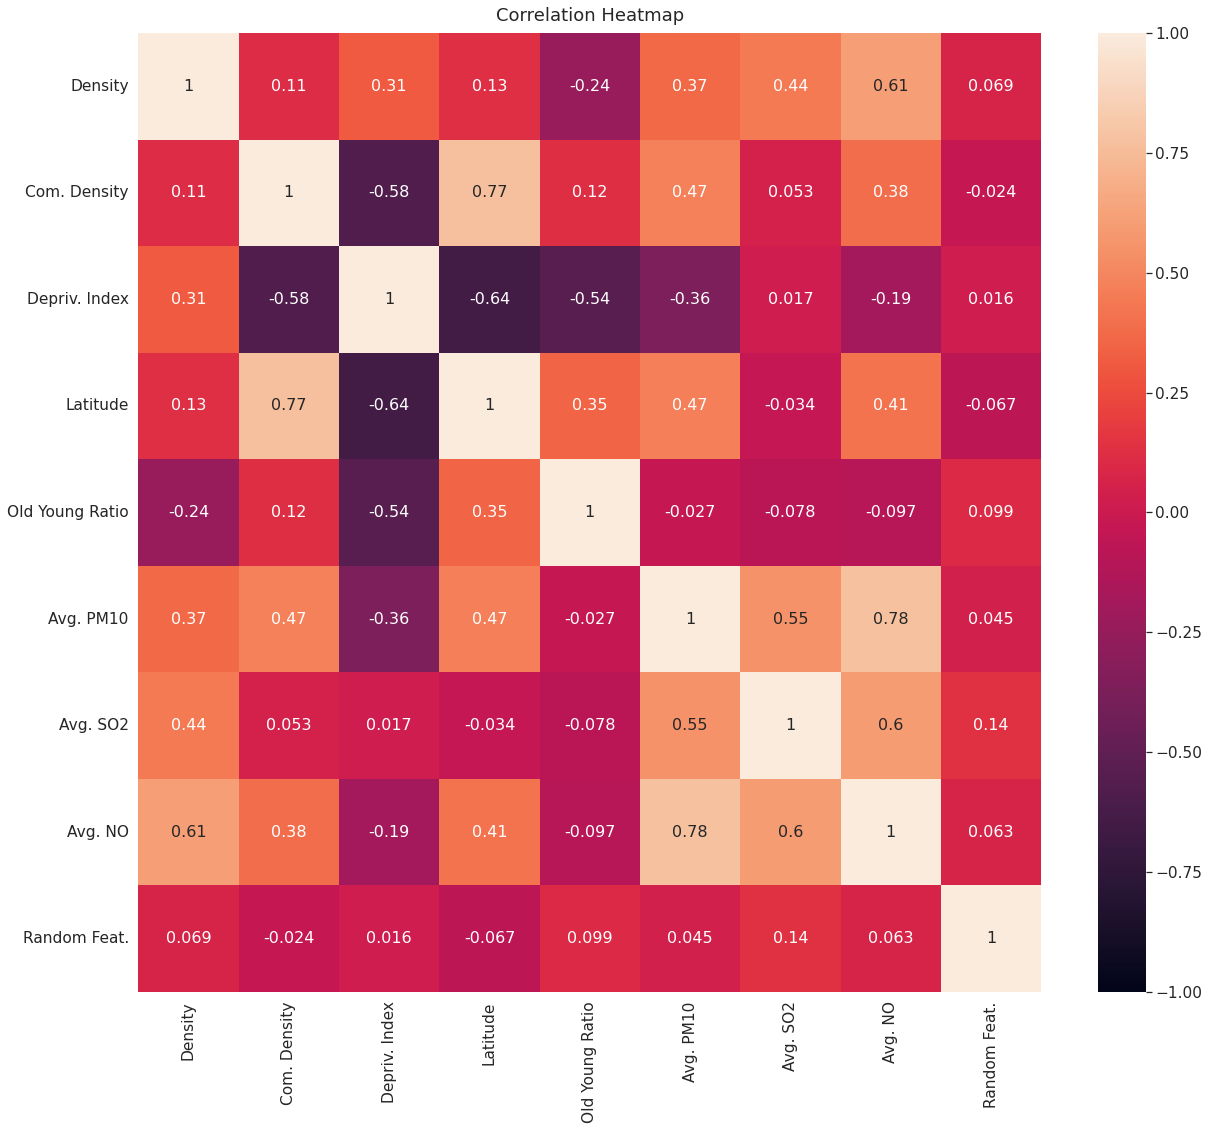

In [7]:
import seaborn as sns

featuresused = features

evaluatecorrelation = {}

for v in featuresused:
    vname = feats_innet_to_visualnamemap[v]
    evaluatecorrelation[vname] = features_dict[v]

plt.figure(figsize=(18, 16))
features_df = pd.DataFrame.from_dict(evaluatecorrelation)

sns.set(font_scale=1.4)
heatmap = sns.heatmap(features_df.corr(),vmin=-1, vmax=1, annot=True , annot_kws={"size": 16});
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

figure = heatmap.get_figure()    
figure.subplots_adjust()
figure.tight_layout()
figure.savefig('heatmap.png',  bbox_inches="tight", pad_inches=0.5)


Grid Search to optimize the RMSE on the Full Set

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.33438  0.01828 
    Test set average RMSE:  0.90417  0.09642 

Prediction STD :    1.25631
True value STD :    1.43281
Difference in percentage:   12.31818

             Fullset RMSE:    0.32910
                       R2:    0.94724


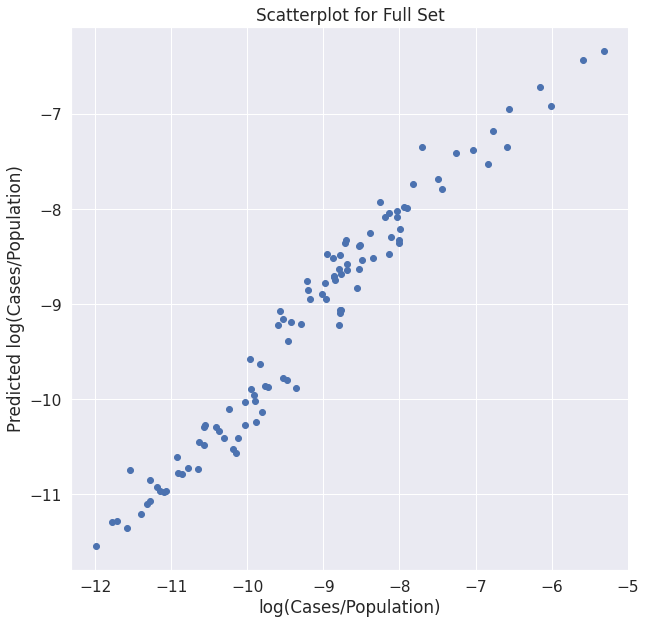

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.05790 +/- 0.00519
Feature:                   Com. Density, Score: 0.21918 +/- 0.03643
Feature:                  Depriv. Index, Score: 0.12309 +/- 0.01516
Feature:                       Latitude, Score: 0.93226 +/- 0.11246
Feature:                Old Young Ratio, Score: 0.10753 +/- 0.01528
Feature:                      Avg. PM10, Score: 0.16549 +/- 0.02249
Feature:                       Avg. SO2, Score: 0.08450 +/- 0.00892
Feature:                        Avg. NO, Score: 0.22498 +/- 0.02422


<Figure size 432x288 with 0 Axes>

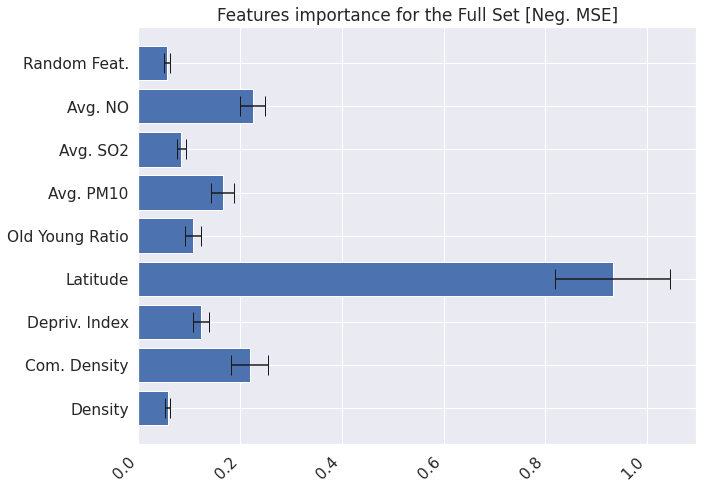

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.02820 +/- 0.00253
Feature:                   Com. Density, Score: 0.10676 +/- 0.01775
Feature:                  Depriv. Index, Score: 0.05996 +/- 0.00739
Feature:                       Latitude, Score: 0.45411 +/- 0.05478
Feature:                Old Young Ratio, Score: 0.05238 +/- 0.00744
Feature:                      Avg. PM10, Score: 0.08061 +/- 0.01096
Feature:                       Avg. SO2, Score: 0.04116 +/- 0.00435
Feature:                        Avg. NO, Score: 0.10959 +/- 0.01180


<Figure size 432x288 with 0 Axes>

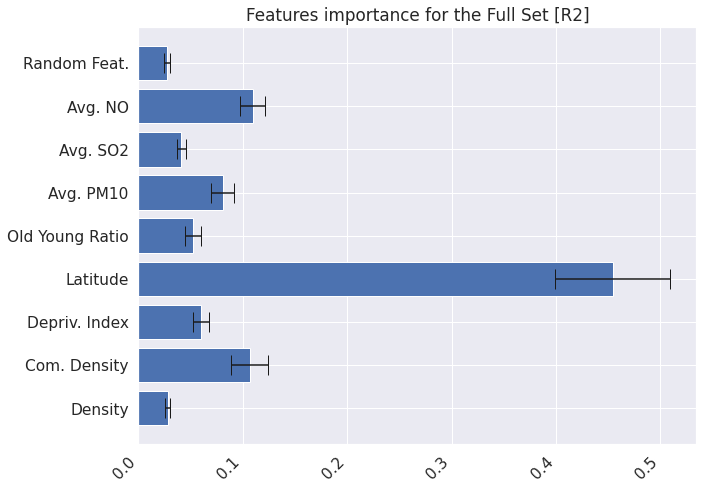

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.34414
                       R2:    0.94852


<Figure size 432x288 with 0 Axes>

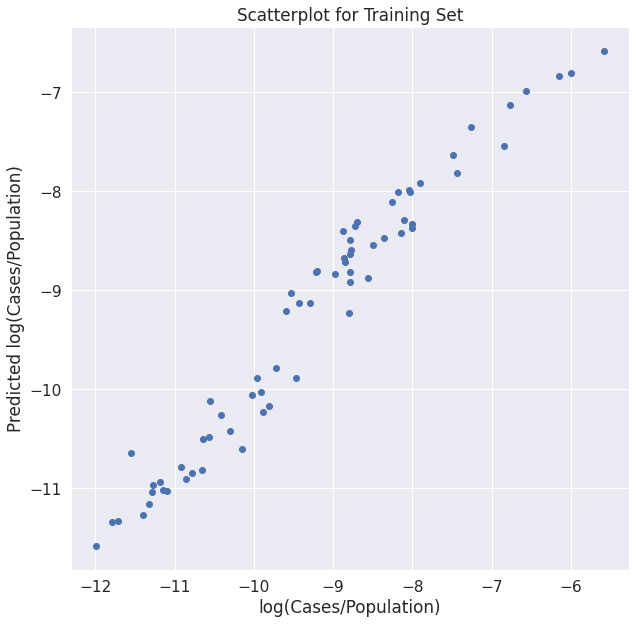

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    0.79534
                       R2:    0.60069


<Figure size 432x288 with 0 Axes>

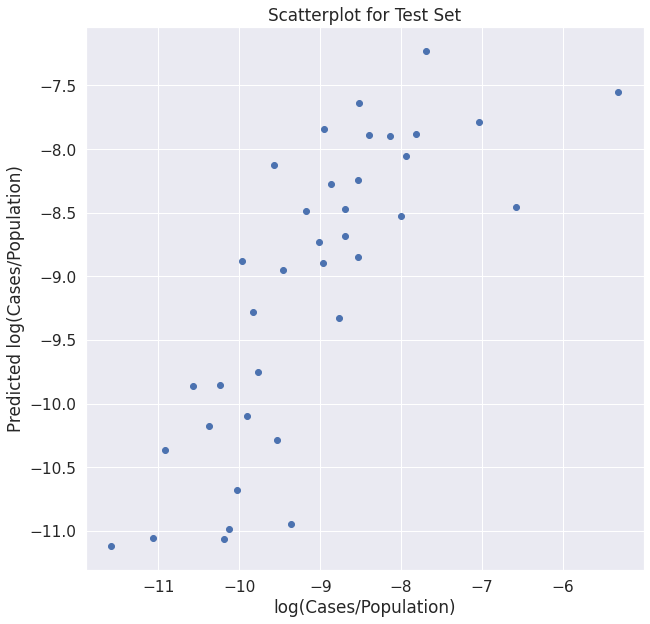

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.00884 +/- 0.06992
Feature:                  Depriv. Index, Score: 0.01791 +/- 0.02562
Feature:                       Latitude, Score: 0.48079 +/- 0.17374
Feature:                Old Young Ratio, Score: 0.03704 +/- 0.01807
Feature:                      Avg. PM10, Score: 0.06231 +/- 0.04221
Feature:                       Avg. SO2, Score: 0.02224 +/- 0.01610
Feature:                        Avg. NO, Score: 0.07327 +/- 0.08497


<Figure size 432x288 with 0 Axes>

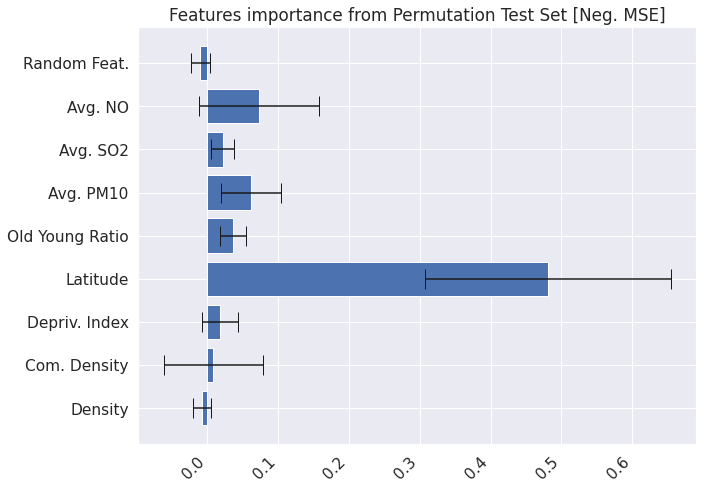

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                   Com. Density, Score: 0.00558 +/- 0.04414
Feature:                  Depriv. Index, Score: 0.01131 +/- 0.01617
Feature:                       Latitude, Score: 0.30350 +/- 0.10967
Feature:                Old Young Ratio, Score: 0.02338 +/- 0.01141
Feature:                      Avg. PM10, Score: 0.03933 +/- 0.02665
Feature:                       Avg. SO2, Score: 0.01404 +/- 0.01016
Feature:                        Avg. NO, Score: 0.04625 +/- 0.05364


<Figure size 432x288 with 0 Axes>

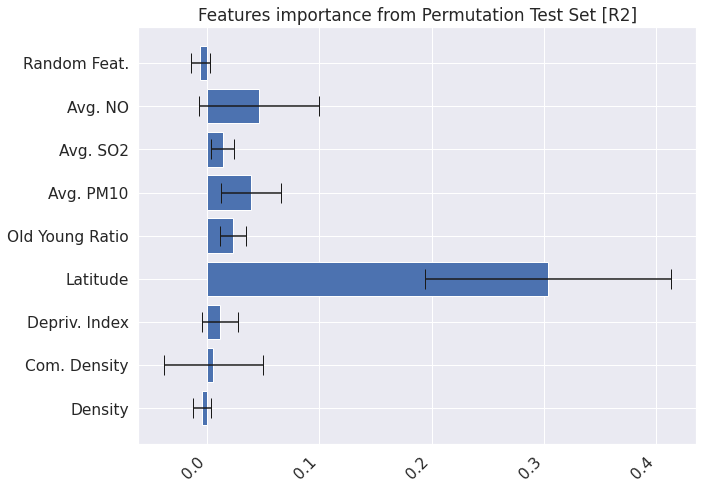

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.25231 +/- 0.04382
Feature:                  Depriv. Index, Score: 0.09459 +/- 0.01718
Feature:                       Latitude, Score: 0.93800 +/- 0.12838
Feature:                Old Young Ratio, Score: 0.07387 +/- 0.01125
Feature:                      Avg. PM10, Score: 0.14393 +/- 0.02055
Feature:                       Avg. SO2, Score: 0.08090 +/- 0.01027
Feature:                        Avg. NO, Score: 0.32514 +/- 0.04826


<Figure size 432x288 with 0 Axes>

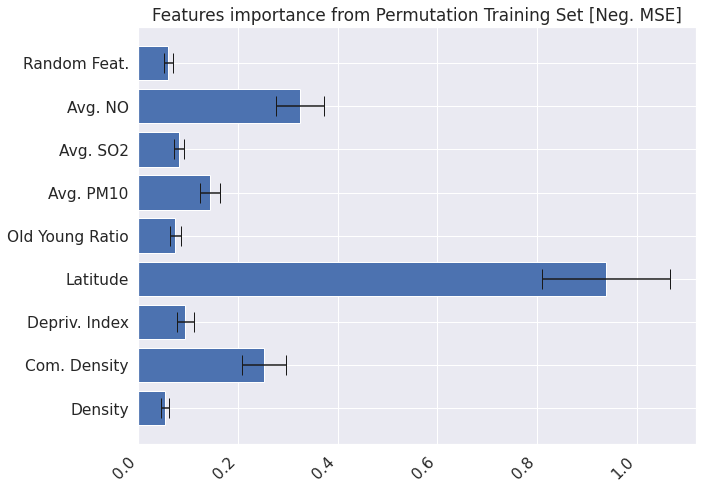

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                   Com. Density, Score: 0.10967 +/- 0.01905
Feature:                  Depriv. Index, Score: 0.04111 +/- 0.00747
Feature:                       Latitude, Score: 0.40770 +/- 0.05580
Feature:                Old Young Ratio, Score: 0.03211 +/- 0.00489
Feature:                      Avg. PM10, Score: 0.06256 +/- 0.00893
Feature:                       Avg. SO2, Score: 0.03516 +/- 0.00446
Feature:                        Avg. NO, Score: 0.14132 +/- 0.02098


<Figure size 432x288 with 0 Axes>

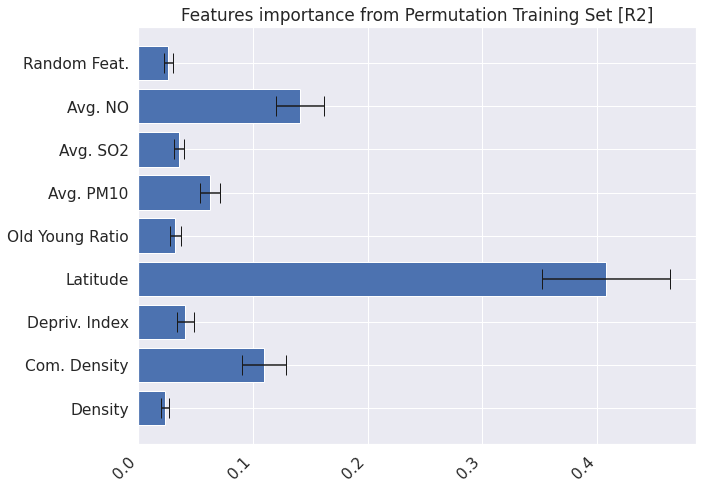

<Figure size 720x720 with 0 Axes>

In [8]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)
#pprint(besthyperF)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout,\
                plotname="allfeatures_opt_fullset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.35712  0.02259 
    Test set average RMSE:  0.99309  0.09327 

Prediction STD :    1.20948
True value STD :    1.43281
Difference in percentage:   15.58650

             Fullset RMSE:    0.35271
                       R2:    0.93940


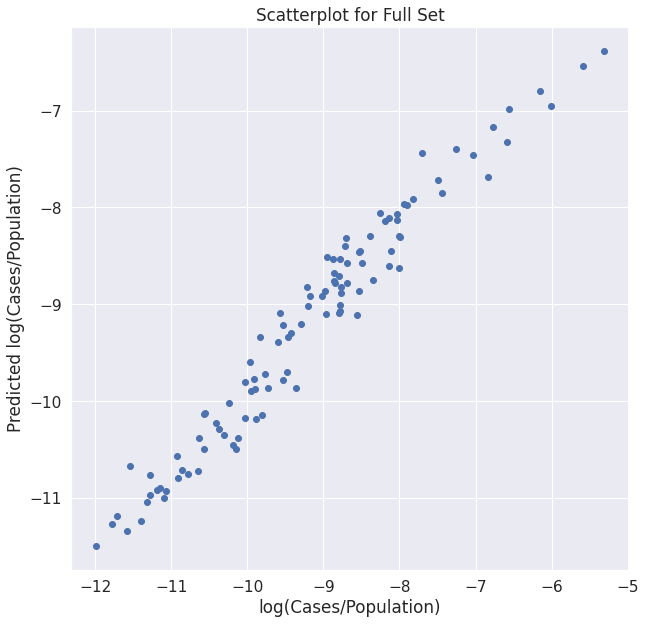

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.10057 +/- 0.01075
Feature:                   Com. Density, Score: 0.57452 +/- 0.07247
Feature:                  Depriv. Index, Score: 0.29418 +/- 0.04170
Feature:                Old Young Ratio, Score: 0.15118 +/- 0.01621
Feature:                      Avg. PM10, Score: 0.26948 +/- 0.03863
Feature:                       Avg. SO2, Score: 0.15235 +/- 0.01590
Feature:                        Avg. NO, Score: 0.33168 +/- 0.03678


<Figure size 432x288 with 0 Axes>

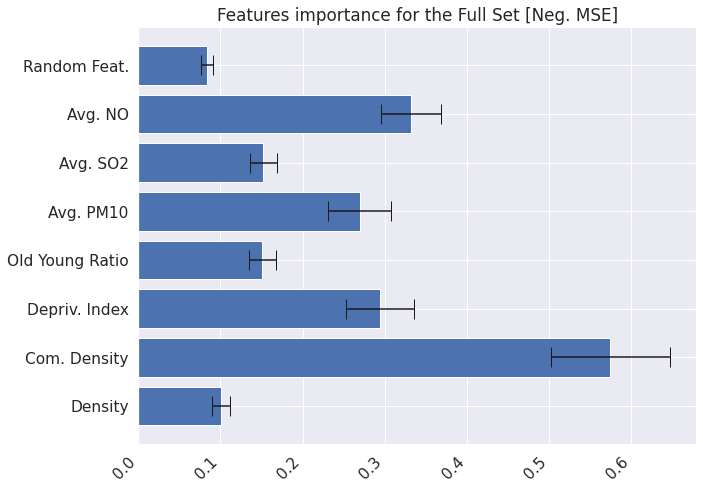

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.04899 +/- 0.00524
Feature:                   Com. Density, Score: 0.27985 +/- 0.03530
Feature:                  Depriv. Index, Score: 0.14330 +/- 0.02031
Feature:                Old Young Ratio, Score: 0.07364 +/- 0.00790
Feature:                      Avg. PM10, Score: 0.13126 +/- 0.01882
Feature:                       Avg. SO2, Score: 0.07421 +/- 0.00774
Feature:                        Avg. NO, Score: 0.16156 +/- 0.01791


<Figure size 432x288 with 0 Axes>

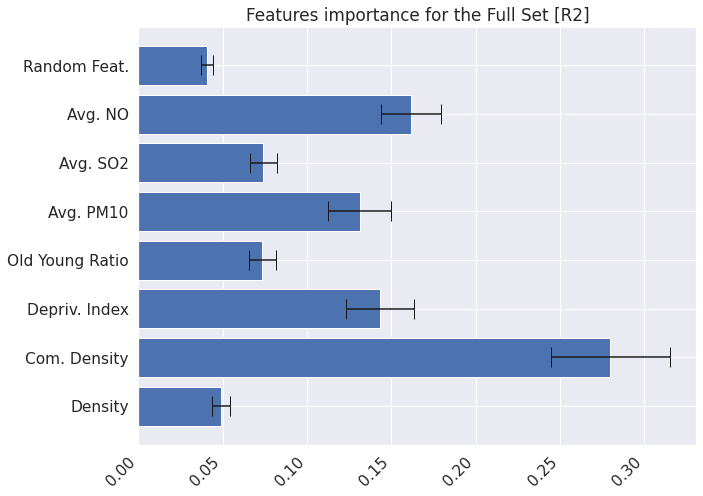

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.39057
                       R2:    0.93369


<Figure size 432x288 with 0 Axes>

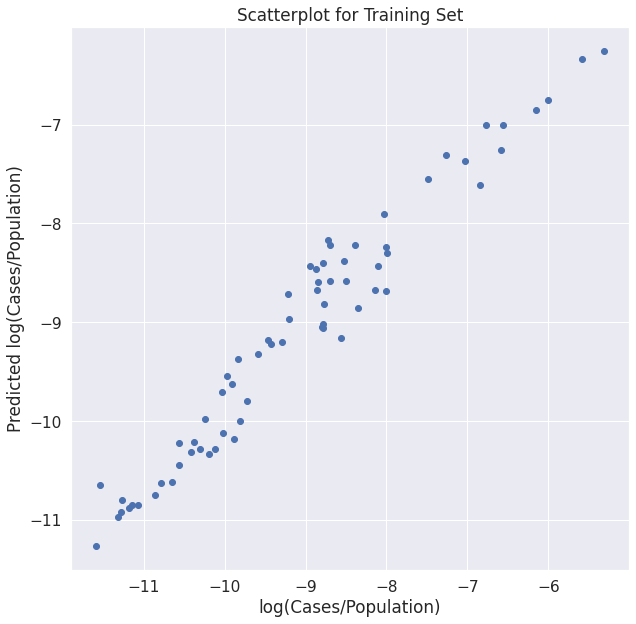

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    0.84065
                       R2:    0.54057


<Figure size 432x288 with 0 Axes>

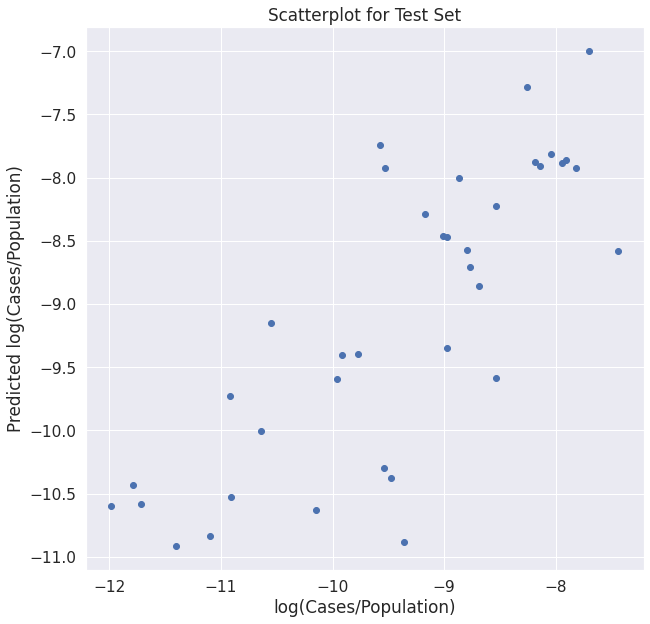

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                   Com. Density, Score: 0.32584 +/- 0.12364
Feature:                  Depriv. Index, Score: 0.08368 +/- 0.05279
Feature:                Old Young Ratio, Score: 0.03356 +/- 0.02391
Feature:                      Avg. PM10, Score: 0.05736 +/- 0.08030
Feature:                        Avg. NO, Score: 0.05287 +/- 0.08121


<Figure size 432x288 with 0 Axes>

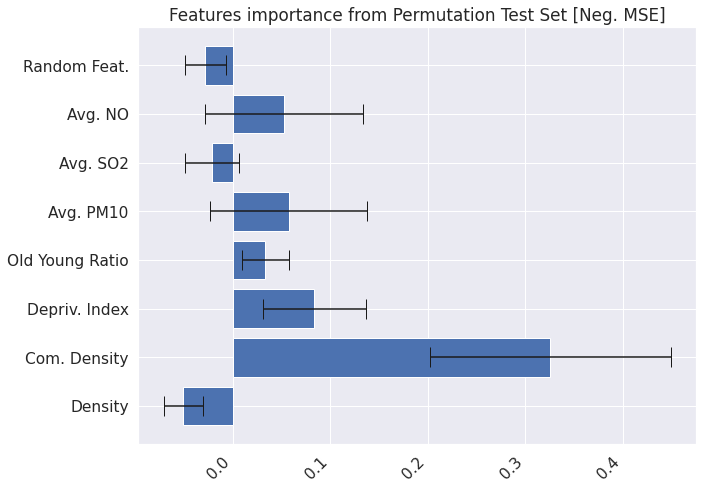

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                   Com. Density, Score: 0.21183 +/- 0.08038
Feature:                  Depriv. Index, Score: 0.05440 +/- 0.03432
Feature:                Old Young Ratio, Score: 0.02182 +/- 0.01555
Feature:                      Avg. PM10, Score: 0.03729 +/- 0.05220
Feature:                        Avg. NO, Score: 0.03437 +/- 0.05279


<Figure size 432x288 with 0 Axes>

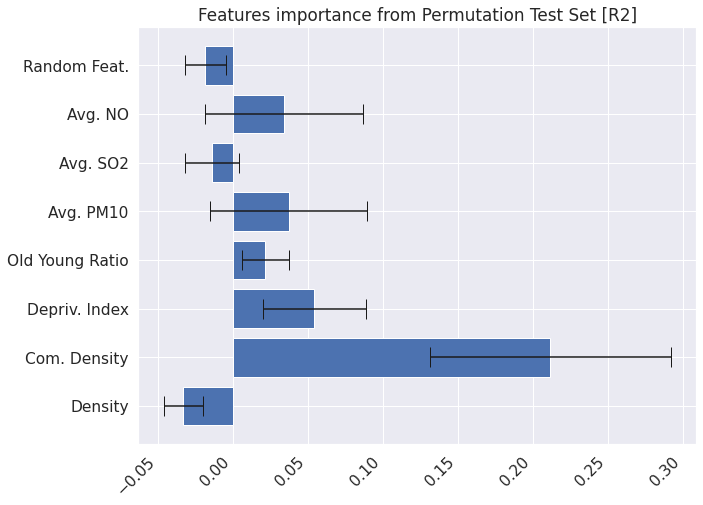

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.12474 +/- 0.01418
Feature:                   Com. Density, Score: 0.48991 +/- 0.07392
Feature:                  Depriv. Index, Score: 0.27202 +/- 0.04442
Feature:                Old Young Ratio, Score: 0.14574 +/- 0.01730
Feature:                      Avg. PM10, Score: 0.41659 +/- 0.06115
Feature:                       Avg. SO2, Score: 0.17077 +/- 0.02547
Feature:                        Avg. NO, Score: 0.39990 +/- 0.06269


<Figure size 432x288 with 0 Axes>

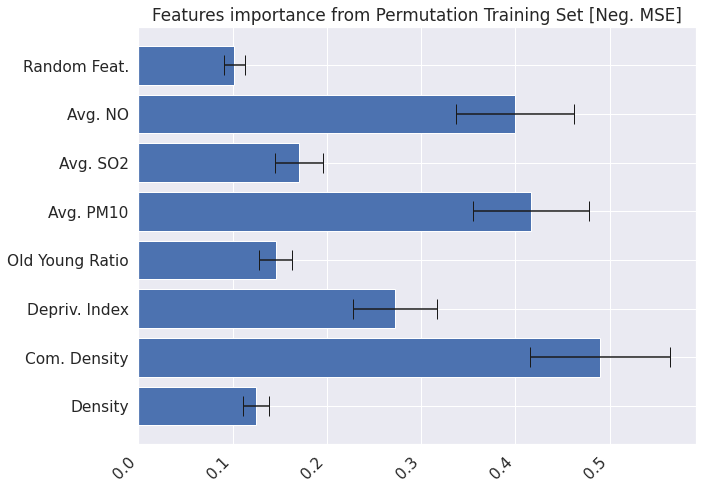

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                        Density, Score: 0.05423 +/- 0.00616
Feature:                   Com. Density, Score: 0.21297 +/- 0.03213
Feature:                  Depriv. Index, Score: 0.11825 +/- 0.01931
Feature:                Old Young Ratio, Score: 0.06335 +/- 0.00752
Feature:                      Avg. PM10, Score: 0.18109 +/- 0.02658
Feature:                       Avg. SO2, Score: 0.07423 +/- 0.01107
Feature:                        Avg. NO, Score: 0.17384 +/- 0.02725


<Figure size 432x288 with 0 Axes>

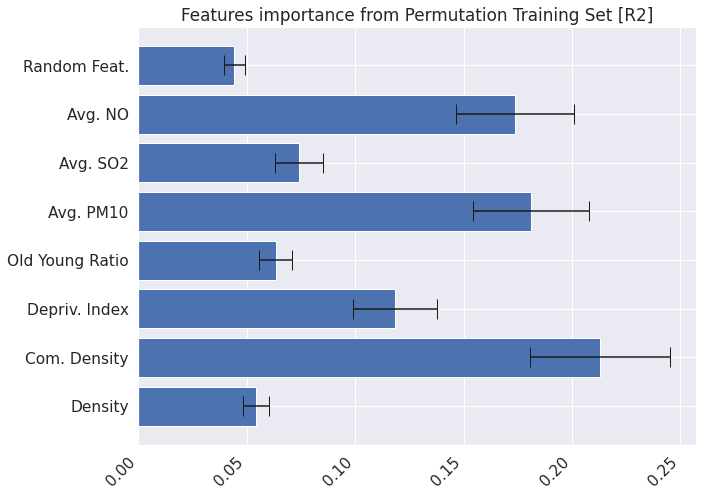

<Figure size 720x720 with 0 Axes>

In [9]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

#print(besthyperF, best_diff, best_test_rmse, best_train_rmse)


featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_opt_fullset", showplot=True, optimisedparams=besthyperF, \
                    visualmap=feats_innet_to_visualnamemap )

Starting...
[============================================================] 100.0% ...
Done
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Training set average RMSE:  0.38200  0.02662 
    Test set average RMSE:  1.02863  0.11162 

Prediction STD :    1.19141
True value STD :    1.43281
Difference in percentage:   16.84795

             Fullset RMSE:    0.37149
                       R2:    0.93278


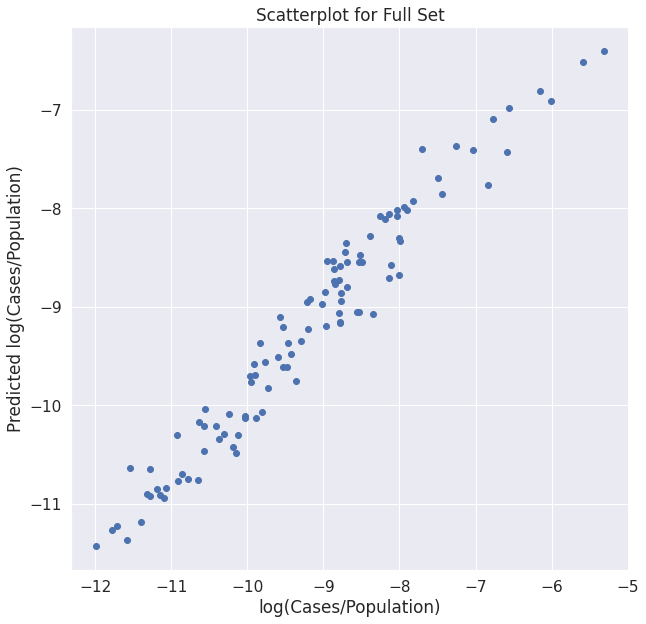

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Fullset Score neg_mean_squared_error : 
Feature:                        Density, Score: 0.12630 +/- 0.01429
Feature:                  Depriv. Index, Score: 0.55952 +/- 0.07628
Feature:                Old Young Ratio, Score: 0.18973 +/- 0.02042
Feature:                      Avg. PM10, Score: 0.40586 +/- 0.05450
Feature:                       Avg. SO2, Score: 0.18962 +/- 0.01804
Feature:                        Avg. NO, Score: 0.60368 +/- 0.06567


<Figure size 432x288 with 0 Axes>

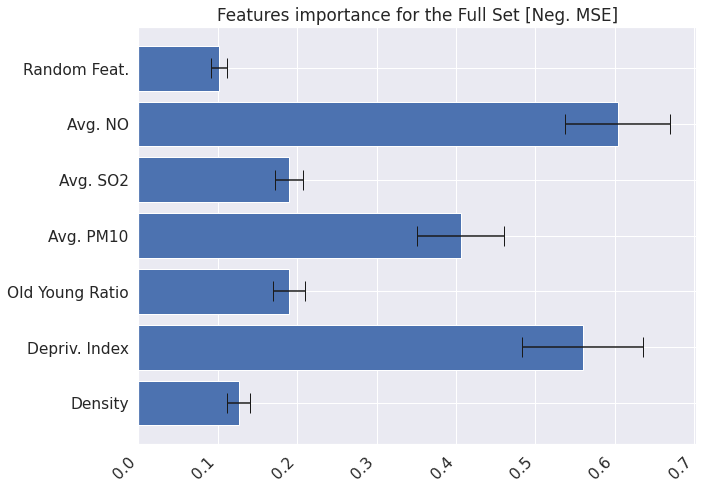

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Full Set Score r2: 
Feature:                        Density, Score: 0.06152 +/- 0.00696
Feature:                  Depriv. Index, Score: 0.27255 +/- 0.03716
Feature:                Old Young Ratio, Score: 0.09242 +/- 0.00995
Feature:                      Avg. PM10, Score: 0.19770 +/- 0.02655
Feature:                       Avg. SO2, Score: 0.09237 +/- 0.00879
Feature:                        Avg. NO, Score: 0.29406 +/- 0.03199


<Figure size 432x288 with 0 Axes>

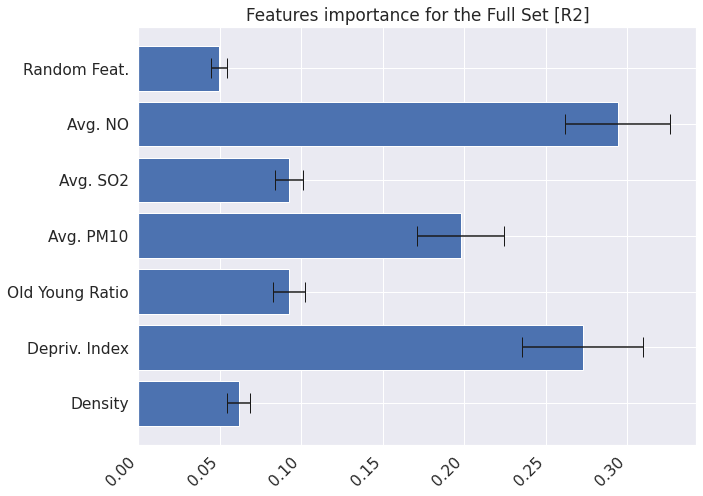

<Figure size 720x720 with 0 Axes>

         Trainingset RMSE:    0.37382
                       R2:    0.92620


<Figure size 432x288 with 0 Axes>

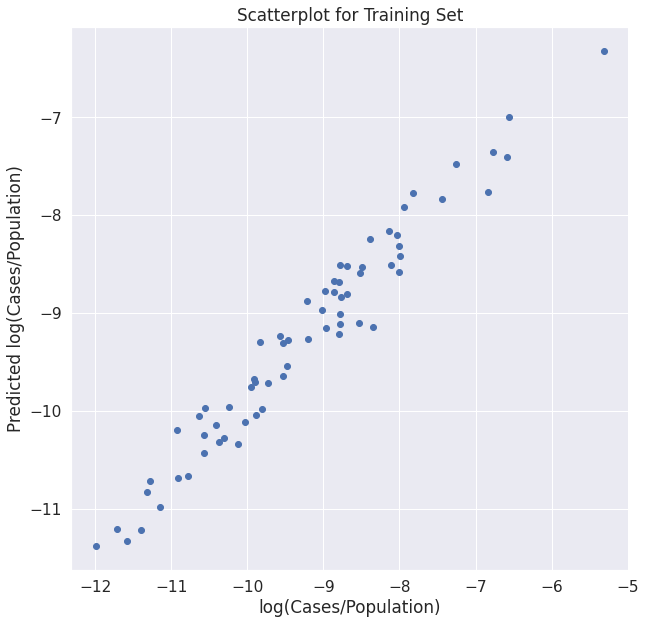

<Figure size 720x720 with 0 Axes>

             Testset RMSE:    1.03726
                       R2:    0.53785


<Figure size 432x288 with 0 Axes>

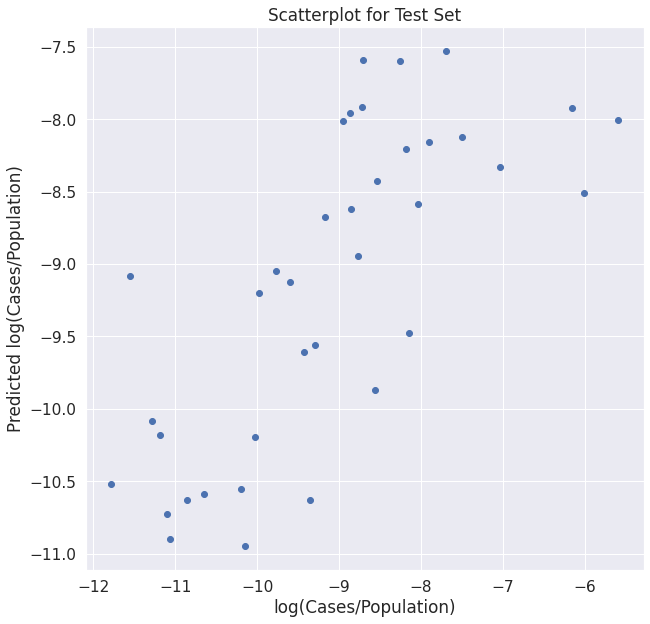

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TetSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.43449 +/- 0.14202
Feature:                Old Young Ratio, Score: 0.00891 +/- 0.03765
Feature:                      Avg. PM10, Score: 0.27325 +/- 0.08780
Feature:                       Avg. SO2, Score: 0.03732 +/- 0.03728
Feature:                        Avg. NO, Score: 0.36853 +/- 0.13995


<Figure size 432x288 with 0 Axes>

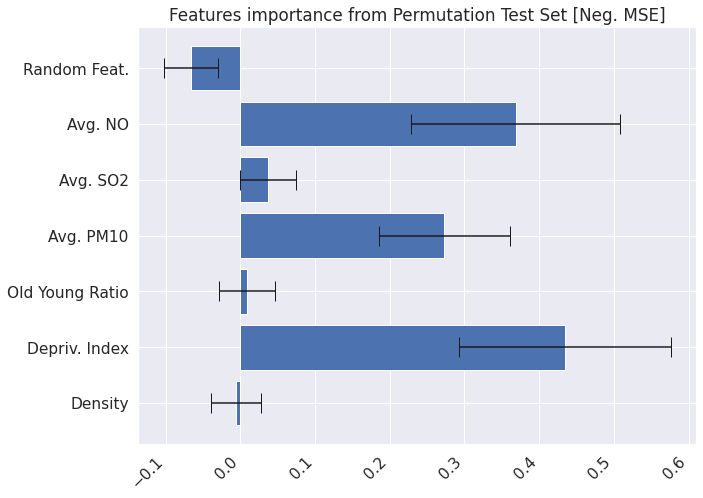

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TestSet Score r2: 
Feature:                  Depriv. Index, Score: 0.18663 +/- 0.06100
Feature:                Old Young Ratio, Score: 0.00383 +/- 0.01617
Feature:                      Avg. PM10, Score: 0.11737 +/- 0.03771
Feature:                       Avg. SO2, Score: 0.01603 +/- 0.01601
Feature:                        Avg. NO, Score: 0.15830 +/- 0.06011


<Figure size 432x288 with 0 Axes>

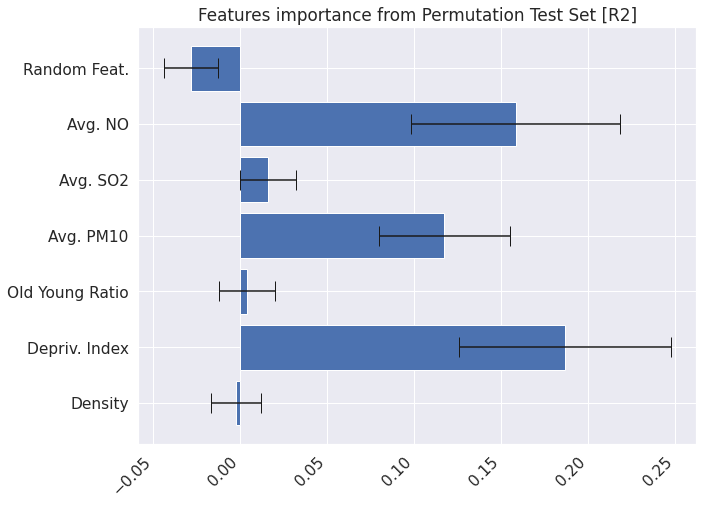

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score neg_mean_squared_error : 
Feature:                  Depriv. Index, Score: 0.59520 +/- 0.08772
Feature:                Old Young Ratio, Score: 0.14231 +/- 0.02097
Feature:                      Avg. PM10, Score: 0.31305 +/- 0.04772
Feature:                       Avg. SO2, Score: 0.17968 +/- 0.02328
Feature:                        Avg. NO, Score: 0.47647 +/- 0.07196


<Figure size 432x288 with 0 Axes>

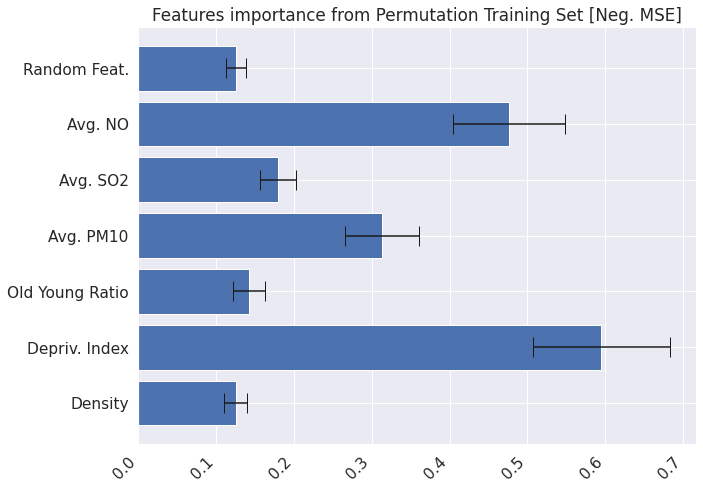

<Figure size 720x720 with 0 Axes>


Features importance from Permutation TrainingSet Score r2: 
Feature:                  Depriv. Index, Score: 0.31436 +/- 0.04633
Feature:                Old Young Ratio, Score: 0.07516 +/- 0.01108
Feature:                      Avg. PM10, Score: 0.16534 +/- 0.02520
Feature:                       Avg. SO2, Score: 0.09490 +/- 0.01230
Feature:                        Avg. NO, Score: 0.25165 +/- 0.03801


<Figure size 432x288 with 0 Axes>

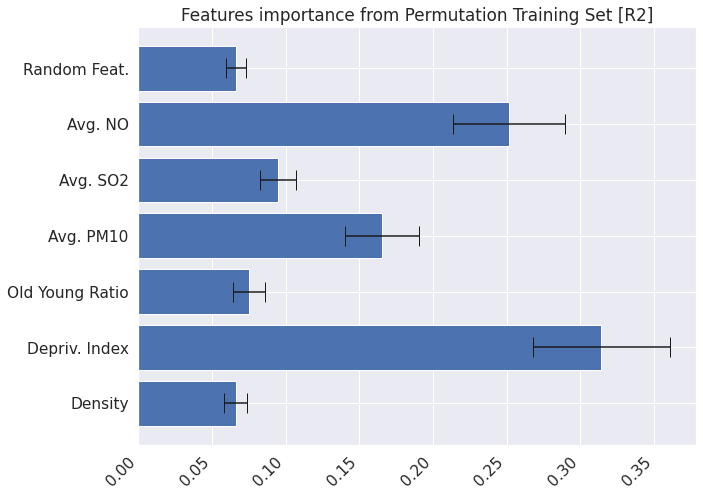

<Figure size 720x720 with 0 Axes>

In [10]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF, best_rmse  = \
    smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
trainavgrmse, testavgrmse, fullsetrmse, featimport, featimport2,  \
        featimport3, featimport4, featimport5, featimport6 = \
            smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, \
                plotname="nolat_nocommut_opt_fullset", showplot=True, \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap)

Using mutiple split test and training 

In [11]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF = None
besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_split_testtr(X, Y, NSPLIT=5, inboot=[True])

pprint(besthyperF)

Starting...
[============================================================] 100.0% ...
Done
{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500,
 'random_state': 1}


In [12]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors_multitestset (X, Y , featuresused, N=200, pout=sys.stdout, \
                plotname="allfeatures_opt_multitestset", \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap, \
                        NFI=10)

Starting...
[============================================================] 100.0% ...
Done
Training set average RMSE:  0.33434 +/-  0.02160 
    Test set average RMSE:  0.90072 +/-  0.09460 
  Training set average R2:  0.94492 +/-  0.00579 
      Test set average R2:  0.59053 +/-  0.07082 
Taining:
             Density ,    0.05489 +/-    0.01099 ,   -0.00630 +/-    0.01003 ,    0.00000 ,    0.00000 ,    0.00000 ,    0.50000
        Com. Density ,    0.21986 +/-    0.04194 ,    0.05601 +/-    0.03119 ,    0.00000 ,   48.00000 ,    0.00000 ,   71.00000
       Depriv. Index ,    0.11712 +/-    0.03009 ,    0.01467 +/-    0.01678 ,    0.00000 ,    1.00000 ,    0.00000 ,    1.00000
            Latitude ,    0.76168 +/-    0.09681 ,    0.31910 +/-    0.05755 ,  100.00000 ,    0.00000 ,  100.00000 ,    0.00000
     Old Young Ratio ,    0.10108 +/-    0.02719 ,    0.00621 +/-    0.01584 ,    0.00000 ,    0.00000 ,    0.00000 ,    4.00000
           Avg. PM10 ,    0.16499 +/-    0.05109 ,    0

<Figure size 720x720 with 0 Axes>

In [13]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF = None
besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_split_testtr(X, Y, NSPLIT=5, inboot=[True])

pprint(besthyperF)

Starting...
[============================================================] 100.0% ...
Done
{'bootstrap': True,
 'max_depth': 25,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500,
 'random_state': 1}


In [14]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors_multitestset (X, Y , featuresused, N=200, pout=sys.stdout, \
                plotname="allfeatures_opt_multitestset", \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap, \
                        NFI=10)

Starting...
[============================================================] 100.0% ...
Done
Training set average RMSE:  0.36617 +/-  0.02586 
    Test set average RMSE:  0.99449 +/-  0.10834 
  Training set average R2:  0.93445 +/-  0.00751 
      Test set average R2:  0.48802 +/-  0.10321 
Taining:
             Density ,    0.06412 +/-    0.02152 ,   -0.00454 +/-    0.01707 ,    0.00000 ,    0.00000 ,    0.00000 ,    1.00000
        Com. Density ,    1.43648 +/-    0.42325 ,    0.56086 +/-    0.14717 ,   94.50000 ,    5.50000 ,   99.00000 ,    1.00000
       Depriv. Index ,    0.09261 +/-    0.04801 ,    0.01031 +/-    0.01866 ,    0.00000 ,    1.50000 ,    0.00000 ,    0.50000
     Old Young Ratio ,    0.18847 +/-    0.07943 ,    0.03908 +/-    0.03448 ,    0.00000 ,   12.00000 ,    0.00000 ,   21.50000
           Avg. PM10 ,    0.21212 +/-    0.13236 ,    0.02015 +/-    0.03540 ,    0.50000 ,   23.00000 ,    0.00000 ,   12.00000
            Avg. SO2 ,    0.08323 +/-    0.03015 ,    0

<Figure size 720x720 with 0 Axes>

In [15]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

besthyperF = None
besthyperF,best_diff, best_test_rmse, best_train_rmse  = \
    smlmodule.rfregressors_custom_optimizer_split_testtr(X, Y, NSPLIT=5, inboot=[True])

pprint(besthyperF)

Starting...
[============================================================] 100.0% ...
Done
{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 800,
 'random_state': 1}


In [16]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors_multitestset (X, Y , featuresused, N=200, pout=sys.stdout, \
                plotname="allfeatures_opt_multitestset", \
                    optimisedparams=besthyperF, visualmap=feats_innet_to_visualnamemap, \
                        NFI=10)

Starting...
[============================================================] 100.0% ...
Done
Training set average RMSE:  0.38234 +/-  0.02372 
    Test set average RMSE:  1.03024 +/-  0.10670 
  Training set average R2:  0.92825 +/-  0.00692 
      Test set average R2:  0.46000 +/-  0.08930 
Taining:
             Density ,    0.12703 +/-    0.02423 ,   -0.00324 +/-    0.01852 ,    0.00000 ,    0.00000 ,    0.00000 ,    0.00000
       Depriv. Index ,    0.50096 +/-    0.10329 ,    0.18475 +/-    0.04238 ,   39.50000 ,   40.50000 ,   63.50000 ,   32.00000
     Old Young Ratio ,    0.16663 +/-    0.03154 ,    0.01415 +/-    0.01679 ,    0.00000 ,    0.00000 ,    0.00000 ,    0.50000
           Avg. PM10 ,    0.39170 +/-    0.09154 ,    0.08923 +/-    0.04173 ,    4.50000 ,   20.00000 ,    0.00000 ,   10.50000
            Avg. SO2 ,    0.16817 +/-    0.03657 ,    0.02301 +/-    0.01962 ,    0.00000 ,    0.00000 ,    0.00000 ,    1.00000
             Avg. NO ,    0.54840 +/-    0.11207 ,    0

<Figure size 720x720 with 0 Axes>